Initial launch parameters:
::::::::::::::::::::::::::::
Position=[0, 0]
Velocity=50 m/s at 30 degrees
dt=0.1
Steps=100
Measurement noise covariances: R=
[[0.5 0. ]
 [0.  0.5]]
Process noise covariance: Q=
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

STEP 0:
Measurement: [4.03042943 3.25498044]
True State: [4.33012702 2.5       ]
Estimated State: [4.00909772 3.26707326]

....................................
STEP 1:
Measurement: [8.71462819 5.34409529]
True State: [8.66025404 4.9019    ]
Estimated State: [8.43657114 5.69141151]

....................................
STEP 2:
Measurement: [12.60356446  8.56685435]
True State: [12.99038106  7.2057    ]
Estimated State: [12.46583432  8.70818941]

....................................
STEP 3:
Measurement: [18.73536942  8.97985355]
True State: [17.32050808  9.4114    ]
Estimated State: [18.09740704  9.74283017]

....................................
STEP 4:
Measurement: [21.76765846 10.51599547]
True State: [21.65063509 11.519   

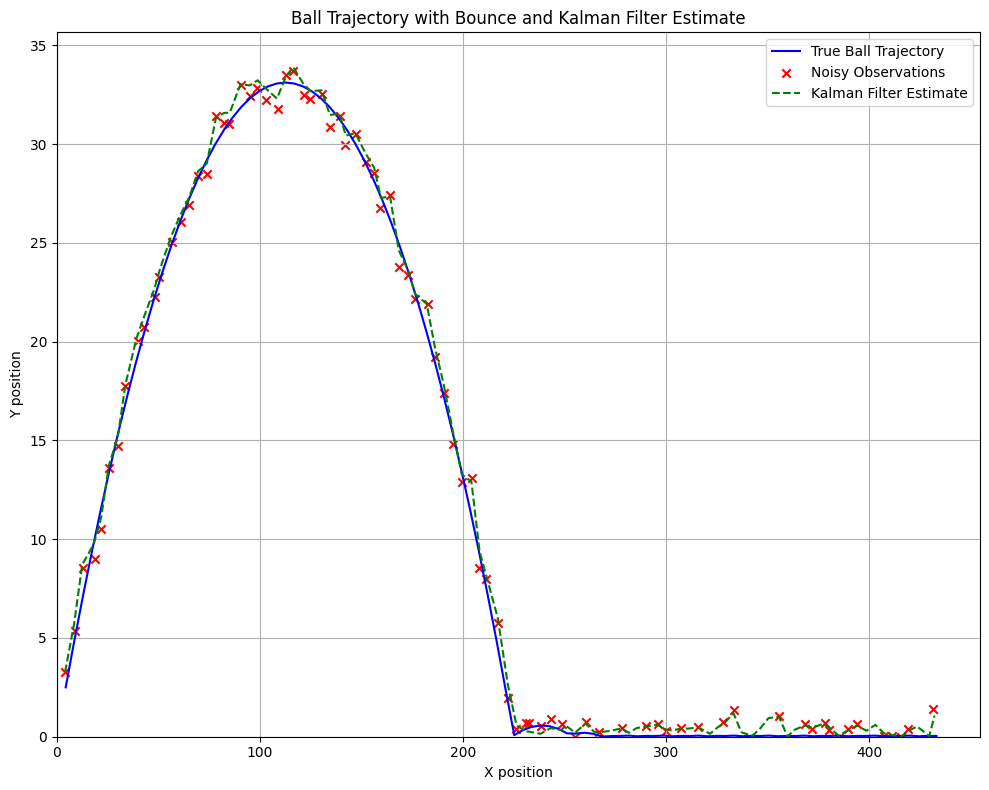

Total time taken: 2.26 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time # to calculate  the runtime

# Record the start time
start_time = time.time()

# tunable parameters
dt = 0.1  # time  interval  for the simulation
total_time = 10  # total  time duration for the simulation
observation_noise_cov = np.diag([0.5, 0.5])  # observation noise covariance

# launch parameters of the ball
launch_params = {'launch_position': [0, 0], 'launch_speed': 50, 'launch_angle': 30}

# initial state mean of the position  and velocity [x, y, vx, vy]
init_state_mean = [0, 0, 50*np.cos(np.deg2rad(45)), 50*np.sin(np.deg2rad(45))]
init_state_cov = np.diag([10, 10, 10, 10])  # initial state covariance
transition_cov = np.diag([1, 1, 1, 1])  # transition covariance

# Kalman Filter initialization
x = np.array(init_state_mean, dtype=float)  # initial state estimate
P = np.array(init_state_cov, dtype=float)  # initial state covariance matrix

A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])  # state transition matrix

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])  # observation model (measurement matrix)

Q = np.array(transition_cov, dtype=float)  # process noise covariance
R = np.array(observation_noise_cov, dtype=float)  # observation noise covariance

# print initial parameters
initial_position = launch_params['launch_position']
initial_velocity = launch_params['launch_speed']
num_steps = int(total_time / dt)

print(f"Initial launch parameters:")
print("::::::::::::::::::::::::::::")
print(f"Position={initial_position}")
print(f"Velocity={initial_velocity} m/s at {launch_params['launch_angle']} degrees")
print(f"dt={dt}")
print(f"Steps={num_steps}")
print(f"Measurement noise covariances: R=\n{R}")
print(f"Process noise covariance: Q=\n{Q}\n")
print("=========================================")

# simulation and Kalman Filter with bounce effect
true_positions = []  # True positions of the ball
estimated_positions = []  # Estimated positions from Kalman Filter
observations = []  # noisy observations

# simulate trajectory and then applied Kalman Filter
position = np.array(launch_params['launch_position'], dtype=float)  # ensure correct initialization
velocity = launch_params['launch_speed'] * np.array([np.cos(np.deg2rad(launch_params['launch_angle'])),
                                                    np.sin(np.deg2rad(launch_params['launch_angle']))], dtype=float)

for step, t in enumerate(np.arange(0, total_time, dt)):
    # true state propagation
    position += velocity * dt
    velocity += np.array([0, -9.81]) * dt  # gravity acceleration

    # to handle the bounce (reflect position and reverse velocity)
    if position[1] < 0:
        position[1] = -position[1]
        velocity[1] *= -0.1  # Reduce speed due to bounce and reverse direction

    true_positions.append(position.copy())

    # generated noisy observation
    observation = position + np.random.multivariate_normal([0, 0], observation_noise_cov)
    observations.append(observation)

    # Prediction step
    x = np.dot(A, x)
    P = np.dot(A, np.dot(P, A.T)) + Q

    # Update step
    y = observation - np.dot(H, x)
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
    x += np.dot(K, y)
    P = P - np.dot(K, np.dot(H, P))

    # handle to the correct state estimate if the ball bounces
    if x[1] < 0:
        x[1] = -x[1]
        x[3] *= -0.4  # Reduce velocity due to bounce and reverse direction

    estimated_positions.append(x[:2])

    # printed information for every step
    print(f"STEP {step}:")
    print(f"Measurement: {observation}")
    print(f"True State: {position}")
    print(f"Estimated State: {x[:2]}\n")
    print("....................................")

true_positions = np.array(true_positions)
estimated_positions = np.array(estimated_positions)
observations = np.array(observations)

# calculated the appropriate metrics  to  evaluate the performance of the filter
errors = true_positions - estimated_positions
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print(f"Kalman Filter Performance score metric \nMSE: {mse:.4f} \nRMSE: {rmse:.4f}")

# visualisation of the results
plt.figure(figsize=(10, 8))
plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Ball Trajectory', color='b')
plt.scatter(observations[:, 0], observations[:, 1], color='r', marker='x', label='Noisy Observations')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label='Kalman Filter Estimate', color='g', linestyle='--')
plt.xlim([0, None])
plt.ylim([0, None])
plt.legend()
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Ball Trajectory with Bounce and Kalman Filter Estimate')
plt.grid(True)
plt.tight_layout()
plt.show()

# record the end time
end_time = time.time()

# calculate the total time taken
total_time = end_time - start_time

# print the start time, end time, and total time taken
print(f"Total time taken: {total_time:.2f} seconds")